In [1]:
from Simulador import Simulador
from Registrador import Registrador
from simpy import Environment
import networkx as nx
from Cenario.GeradorDeCenarios import GeradorDeCenarios, Cenario
from Variaveis import *
from Roteamento.Roteamento import Roteamento
from Roteamento.RoteamentoBestFit import RoteamentoBestFit
from Roteamento.Roteamento_evitando_nodes_pre_desastre import Roteamento_evitando_nodes_pre_desastre
from Roteamento.RoteamentoBestFit_evitando_nodes_pre_desastre import RoteamentoBestFit_evitando_nodes_pre_desastre
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [2]:
env = Environment()
topology = nx.read_weighted_edgelist( "../topology/usa", nodetype=int)


In [3]:
# Criar cenarios

cenario1 = GeradorDeCenarios.gerar_cenario(topology, retorna_lista_de_requisicoes=True, numero_de_requisicoes=NUMERO_DE_REQUISICOES, 
                                                           roteamento_de_desastre = Roteamento_evitando_nodes_pre_desastre, retornar_objetos=True)
cenario1 = cenario1

with open('cenario/cenarios/cenario1.pkl', 'wb') as file:
    pickle.dump(cenario1, file) 


--------------------------------------------------------------------------------------------------------------------------Link  9 11  vai falhar
Link  9 7  vai falhar
Link  9 6  vai falhar
Link  9 6  vai falhar
Link  9 7  vai falhar
Link  9 10  vai falhar
Link  9 11  vai falhar
Link  9 12  vai falhar


In [4]:
#salvar cenarios
cenario1: Cenario = pickle.load(open('cenario/cenarios/cenario1.pkl', 'rb'))

In [93]:
def find_balanced_min_cut(graph: nx.Graph):

    def recover_partition_data(partition, graph: nx.Graph):
        reachable, non_reachable = partition
        cut_edges = [(u, v) for u, v in graph.edges() if (u in reachable and v in non_reachable) or (v in reachable and u in non_reachable)]
        return {
            "partition_1": reachable if len(reachable) < len(non_reachable) else non_reachable,
            "partition_2": non_reachable if len(reachable) < len(non_reachable) else reachable,
            "cut_edges": cut_edges
        }
    # Set default capacities if missing
    for u, v in graph.edges():
        if 'capacity' not in graph[u][v]:
            graph[u][v]['capacity'] = 1  # Default capacity for unweighted edges

    best_cut_value = float("inf")
    best_size_difference = float("inf")
    best_partitions_set = set()  # To store unique partitions
    # Iterate over all pairs of nodes as source (s) and sink (t)
    for s in graph.nodes():
        for t in graph.nodes():
            if s == t:
                continue

            # Skip pairs where there is no path
            if not nx.has_path(graph, s, t):
                continue

            try:
                # Calculate the minimum cut between s and t
                cut_value, partition = nx.minimum_cut(graph, s, t)
                (reachable, non_reachable) = partition

                # Ensure balance between the two partitions
                size_difference = abs(len(reachable) - len(non_reachable))

                # Create a frozenset to compare unique partitions
                partition_frozen = frozenset((frozenset(reachable), frozenset(non_reachable)))

                if (cut_value < best_cut_value or
                    ( cut_value == best_cut_value and size_difference < best_size_difference )):
                    best_cut_value = cut_value
                    best_size_difference = size_difference
                    best_partitions_set = {partition_frozen}  # Reset to only this partition

                elif cut_value == best_cut_value and size_difference == best_size_difference:
                    best_partitions_set.add(partition_frozen)  # Add only if unique

            except nx.NetworkXUnbounded:
                print(f"Unbounded flow for source {s} and sink {t}, skipping this pair.")

    # Create list of partition data
    
    results = []
    for partition in best_partitions_set:
        partition_data = recover_partition_data(partition, graph)
        results.append(partition_data)

    return {
        "partitions": results,
        "min_cut_value": best_cut_value,
        "min_size_difference": best_size_difference
    }

# Example usage
 
def remove_node_from_graph( graph: nx.Graph, nodes: list[int]):
    graph = graph.copy()
    graph.remove_nodes_from(nodes)
    return graph

original_graph = cenario1.topology.topology
dados = []
for node in original_graph.nodes():
    copy_graph = remove_node_from_graph(original_graph, [node])
    dado = find_balanced_min_cut(copy_graph)
    dado["node"] = node
    dados.append(dado)

dados.sort(key=lambda x: x['min_size_difference'])
for dado in dados:
    if dado['min_size_difference'] == 21:
        continue
    print( f"Node {dado['node']} removido, corte minimo = {dado['min_cut_value']}, diferença de tamanho minima = {dado['min_size_difference']}")
    for particao in dado["partitions"]:
        print( f"Arestas de corte {particao["cut_edges"]},\n Partição 1: {list(particao['partition_1'])}, Partição 2: {list(particao['partition_2'])}")
    print("\n\n")


Node 9 removido, corte minimo = 2, diferença de tamanho minima = 7
Arestas de corte [(6, 11), (8, 10)],
 Partição 1: [1, 2, 3, 4, 5, 6, 7, 8], Partição 2: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]



Node 7 removido, corte minimo = 2, diferença de tamanho minima = 15
Arestas de corte [(2, 3), (8, 10)],
 Partição 1: [8, 3, 4, 5], Partição 2: [1, 2, 6, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]



Node 17 removido, corte minimo = 2, diferença de tamanho minima = 17
Arestas de corte [(14, 18), (22, 23)],
 Partição 1: [24, 18, 23], Partição 2: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 19, 20, 21, 22]



Node 6 removido, corte minimo = 1, diferença de tamanho minima = 19
Arestas de corte [(2, 3)],
 Partição 1: [1, 2], Partição 2: [3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]



Node 3 removido, corte minimo = 2, diferença de tamanho minima = 19
Arestas de corte [(1, 6), (2, 6)],
 Partição 1: [1, 2], Partiç

In [5]:
plt.rcParams["figure.dpi"] = 100


In [6]:
#roda cenario1
simulador :Simulador  = Simulador(env=env, topology=topology, status_logger=True, cenario=cenario1)
simulador.run()
dataframe_cenario1 = simulador.salvar_dataframe("_out/resultados/df_cenario1")



10000 requests processed, time : 92.19616259116476
20000 requests processed, time : 182.06931860178466
ISP 0 iniciando migração de 9 para 5 no tempo 220.26554261078263
Status ISP 0, 10.402187785756409% da migração concluída no tempo 254.3344913248878
ISP 4 iniciando migração de 9 para 17 no tempo 271.18414989514724
30000 requests processed, time : 273.2279642986208
ISP 1 iniciando migração de 9 para 1 no tempo 274.7839495834862
Status ISP 0, 20.074397481284297% da migração concluída no tempo 286.0039776101715
Status ISP 1, 10.078634987560315% da migração concluída no tempo 302.38431406488684
Status ISP 4, 10.170740946004786% da migração concluída no tempo 303.13405574880267
Status ISP 0, 30.38533800576214% da migração concluída no tempo 307.1041244499839
Status ISP 1, 20.05748150989726% da migração concluída no tempo 318.75760038910744
ISP 3 iniciando migração de 9 para 20 no tempo 325.3507117407498
Status ISP 0, 40.057547701290034% da migração concluída no tempo 335.2529326110845
ISP 

In [95]:
reg = Registrador.get_intance()
reg.printa_parametros()

Numero de requisicoes por classe:  {1: 22609, 2: 38085, 3: 90670}
Numero de requisicoes bloqueadas por classe:  {1: 6043, 2: 10287, 3: 24420}
Numero de requisicoes por banda:  {100: 21703, 150: 21656, 200: 21517, 250: 21649, 300: 21692, 350: 21525, 400: 21622}
Numero de requisicoes bloqueadas por banda:  {100: 737, 150: 2191, 200: 4002, 250: 6056, 300: 7772, 350: 9389, 400: 10603}
Numero de requisicoes reroteadas por classe:  {1: 2, 2: 4, 3: 7}
Numero de requisicoes reroteadas bloqueadas por classe:  {1: 1, 2: 1, 3: 0}
Numero de requisicoes reroteadas por banda:  {100: 1, 150: 4, 200: 2, 250: 2, 300: 2, 350: 1, 400: 1}
Numero de requisicoes reroteadas bloqueadas por banda:  {100: 0, 150: 0, 200: 1, 250: 0, 300: 1, 350: 0, 400: 0}
Numero de requisicoes:  110353
Numero de requisicoes bloqueadas:  40750
Numero de requisicoes afetadas por desastre:  13
Numero de requisicoes reroteadas aceitas:  11
Numero de requisicoes reroteadas bloqueadas:  2
Momentos da migração concluída:  {0: (462.623

In [7]:
# Carrega cenario
with open('cenario/cenarios/cenario1.pkl', 'rb') as file:
    cenario1:Cenario = pickle.load(file)

dataframe1: pd.DataFrame = pd.read_csv("_out/resultados/df_cenario1.csv")

C:\Users\user\AppData\Local\Temp\ipykernel_9888\3990383418.py:5: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframe1: pd.DataFrame = pd.read_csv("_out/resultados/df_cenario1.csv")


In [8]:
def plota_migracao_e_desastre():
    #plota linhas verticais de inicio de migração
    tempos_de_inicio_migracao_ISP = [ (isp.datacenter.tempo_de_reacao, isp.id) for isp in cenario1.lista_de_ISPs] 

    for x in tempos_de_inicio_migracao_ISP:
        plt.axvline(x=x[0], color='red', linestyle='--', linewidth=1)

    #plota inicio e fim do desastre
    inicio_desastre = cenario1.desastre.start
    fim_desastre = cenario1.desastre.start + cenario1.desastre.duration

    plt.axvline(x=inicio_desastre, color='black', linestyle='--', linewidth=1)
    plt.axvline(x=fim_desastre, color='black', linestyle='--', linewidth=1)


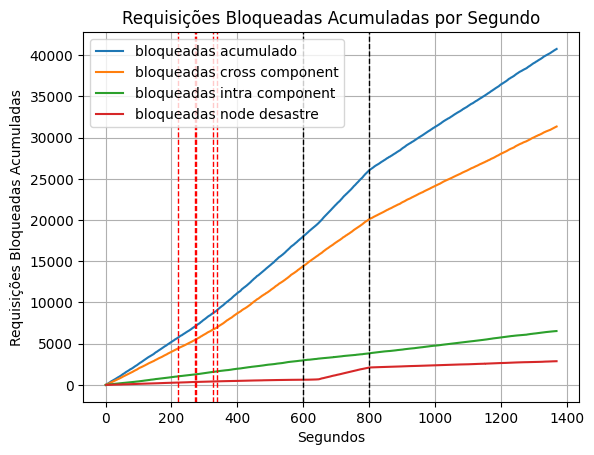

In [9]:
#plota grafico de bloqueadas acumuladas
df_bloqueadas1 = dataframe1[dataframe1["bloqueada"] == True]
df_acumulado_por_segundo1 = df_bloqueadas1.groupby('tempo_criacao').size().cumsum()
plt.plot(df_acumulado_por_segundo1.index, df_acumulado_por_segundo1.values, label=f"bloqueadas acumulado")

#plota grafico de bloqueadas cross componentes acumulada
componente1 = [i for i in range(1, 9)]
componente2 = [i for i in range(10, 25)]

filtered_dataframe = dataframe1[
    ((dataframe1['src'].isin(componente1)) & (dataframe1["dst"].isin(componente2))) | 
    ((dataframe1['src'].isin(componente2)) & (dataframe1["dst"].isin(componente1)))
]

filtered_dataframe_bloqueadas = filtered_dataframe[filtered_dataframe["bloqueada"] == True]
df_acumulado_por_segundo2 = filtered_dataframe_bloqueadas.groupby('tempo_criacao').size().cumsum()
plt.plot(df_acumulado_por_segundo2.index, df_acumulado_por_segundo2.values, label=f"bloqueadas cross component")

#plota grafico de bloqueadas intra componentes acumulada
filtered_dataframe = dataframe1[
    ((dataframe1['src'].isin(componente1)) & (dataframe1["dst"].isin(componente1))) | 
    ((dataframe1['src'].isin(componente2)) & (dataframe1["dst"].isin(componente2)))
]

filtered_dataframe_bloqueadas = filtered_dataframe[filtered_dataframe["bloqueada"] == True]
df_acumulado_por_segundo2 = filtered_dataframe_bloqueadas.groupby('tempo_criacao').size().cumsum()
plt.plot(df_acumulado_por_segundo2.index, df_acumulado_por_segundo2.values, label=f"bloqueadas intra component")

#plota grafico de bloqueadas para desastre acumulada
filtered_dataframe = dataframe1[
    ((dataframe1['src'] == 9)) | 
    ((dataframe1["dst"] == 9))
]

filtered_dataframe_bloqueadas = filtered_dataframe[filtered_dataframe["bloqueada"] == True]
df_acumulado_por_segundo2 = filtered_dataframe_bloqueadas.groupby('tempo_criacao').size().cumsum()
plt.plot(df_acumulado_por_segundo2.index, df_acumulado_por_segundo2.values, label=f"bloqueadas node desastre")


#plota linhas verticais de inicio de migração
plota_migracao_e_desastre()


plt.xlabel('Segundos')
plt.ylabel('Requisições Bloqueadas Acumuladas')
plt.title('Requisições Bloqueadas Acumuladas por Segundo')

plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()

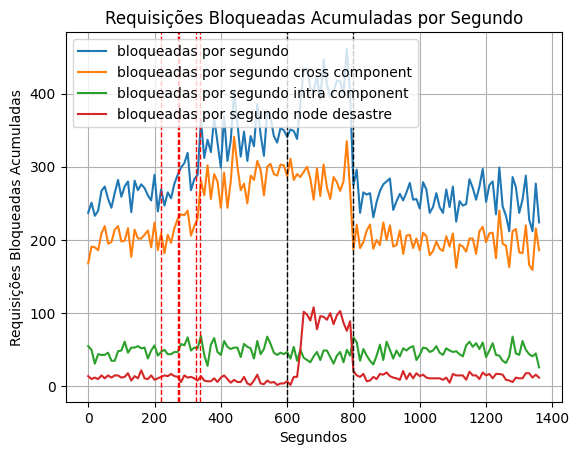

In [10]:
bucket_size = 10
segundos = (dataframe1['tempo_criacao'] // bucket_size) * bucket_size
total_requisicoes_por_segundo1 = dataframe1.groupby(segundos).size()
bloqueadas_por_segundo1 = dataframe1[dataframe1["bloqueada"] == True].groupby(segundos).size()
plt.plot(bloqueadas_por_segundo1.index, bloqueadas_por_segundo1.values, label="bloqueadas por segundo")

# bloqueadas por segundo cross component
componente1 = [i for i in range(1, 9)]
componente2 = [i for i in range(10, 25)]

filtered_dataframe = dataframe1[
    ((dataframe1['src'].isin(componente1)) & (dataframe1["dst"].isin(componente2))) | 
    ((dataframe1['src'].isin(componente2)) & (dataframe1["dst"].isin(componente1)))
]
segundos = (filtered_dataframe['tempo_criacao'] // bucket_size) * bucket_size
total_requisicoes_por_segundo1 = filtered_dataframe.groupby(segundos).size()
bloqueadas_por_segundo1 = filtered_dataframe[filtered_dataframe["bloqueada"] == True].groupby(segundos).size()
plt.plot(bloqueadas_por_segundo1.index, bloqueadas_por_segundo1.values, label="bloqueadas por segundo cross component")

# bloqueadas por segundo intra component
filtered_dataframe = dataframe1[
    ((dataframe1['src'].isin(componente1)) & (dataframe1["dst"].isin(componente1))) | 
    ((dataframe1['src'].isin(componente2)) & (dataframe1["dst"].isin(componente2)))
]
segundos = (filtered_dataframe['tempo_criacao'] // bucket_size) * bucket_size
total_requisicoes_por_segundo1 = filtered_dataframe.groupby(segundos).size()
bloqueadas_por_segundo1 = filtered_dataframe[filtered_dataframe["bloqueada"] == True].groupby(segundos).size()
plt.plot(bloqueadas_por_segundo1.index, bloqueadas_por_segundo1.values, label="bloqueadas por segundo intra component")

# bloqueadas por segundo node desastre
filtered_dataframe = dataframe1[
    ((dataframe1['src'] == 9) | 
    (dataframe1["dst"] == 9 ))
]
segundos = (filtered_dataframe['tempo_criacao'] // bucket_size) * bucket_size
total_requisicoes_por_segundo1 = filtered_dataframe.groupby(segundos).size()
bloqueadas_por_segundo1 = filtered_dataframe[filtered_dataframe["bloqueada"] == True].groupby(segundos).size()
plt.plot(bloqueadas_por_segundo1.index, bloqueadas_por_segundo1.values, label="bloqueadas por segundo node desastre")

plota_migracao_e_desastre()

plt.xlabel('Segundos')
plt.ylabel('Requisições Bloqueadas Acumuladas')
plt.title('Requisições Bloqueadas Acumuladas por Segundo')

plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()

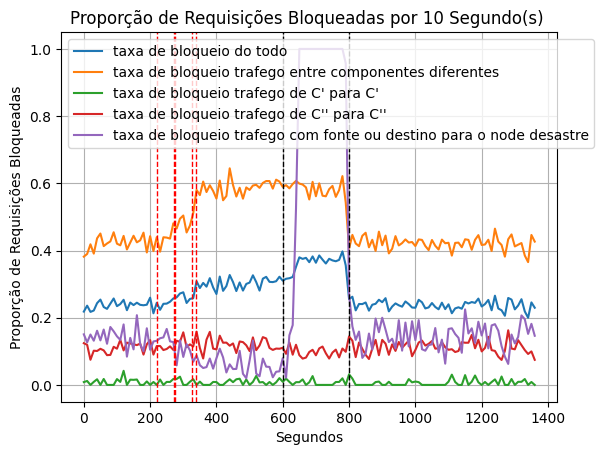

In [11]:
bucket_size = 10
segundos = (dataframe1['tempo_criacao'] // bucket_size) * bucket_size
total_requisicoes_por_segundo1 = dataframe1.groupby(segundos).size()
bloqueadas_por_segundo1 = dataframe1[dataframe1["bloqueada"] == True].groupby(segundos).size()
bloqueadas_por_segundo1 = bloqueadas_por_segundo1.reindex(total_requisicoes_por_segundo1.index, fill_value=0)
proporcao_bloqueadas1 = bloqueadas_por_segundo1 / total_requisicoes_por_segundo1
#plt.plot(proporcao_bloqueadas1.index, proporcao_bloqueadas1.values)
plt.plot(proporcao_bloqueadas1.index, proporcao_bloqueadas1.values, label="taxa de bloqueio do todo")



componente1 = [i for i in range(1, 9)]
componente2 = [i for i in range(10, 25)]

filtered_dataframe = dataframe1[
    ((dataframe1['src'].isin(componente1)) & (dataframe1["dst"].isin(componente2))) | 
    ((dataframe1['src'].isin(componente2)) & (dataframe1["dst"].isin(componente1)))
]
segundos = (filtered_dataframe['tempo_criacao'] // bucket_size) * bucket_size
total_requisicoes_por_segundo1 = filtered_dataframe.groupby(segundos).size()

bloqueadas_por_segundo2 = filtered_dataframe[(filtered_dataframe["bloqueada"] == True)].groupby(segundos).size()
bloqueadas_por_segundo2 = bloqueadas_por_segundo2.reindex(total_requisicoes_por_segundo1.index, fill_value=0)
proporcao_bloqueadas1 = bloqueadas_por_segundo2 / total_requisicoes_por_segundo1
plt.plot(proporcao_bloqueadas1.index, proporcao_bloqueadas1.values, label = "taxa de bloqueio trafego entre componentes diferentes")

#bloqueadas intra componente C1
filtered_dataframe = dataframe1[
    ((dataframe1['src'].isin(componente1)) & (dataframe1["dst"].isin(componente1)))
]
segundos = (filtered_dataframe['tempo_criacao'] // bucket_size) * bucket_size
total_requisicoes_por_segundo1 = filtered_dataframe.groupby(segundos).size()

bloqueadas_por_segundo2 = filtered_dataframe[(filtered_dataframe["bloqueada"] == True)].groupby(segundos).size()
bloqueadas_por_segundo2 = bloqueadas_por_segundo2.reindex(total_requisicoes_por_segundo1.index, fill_value=0)
proporcao_bloqueadas1 = bloqueadas_por_segundo2 / total_requisicoes_por_segundo1
plt.plot(proporcao_bloqueadas1.index, proporcao_bloqueadas1.values, label = "taxa de bloqueio trafego de C' para C'")

#bloqueadas intra componente C2
filtered_dataframe = dataframe1[
    ((dataframe1['src'].isin(componente2)) & (dataframe1["dst"].isin(componente2)))
]
segundos = (filtered_dataframe['tempo_criacao'] // bucket_size) * bucket_size
total_requisicoes_por_segundo1 = filtered_dataframe.groupby(segundos).size()

bloqueadas_por_segundo2 = filtered_dataframe[(filtered_dataframe["bloqueada"] == True)].groupby(segundos).size()
bloqueadas_por_segundo2 = bloqueadas_por_segundo2.reindex(total_requisicoes_por_segundo1.index, fill_value=0)
proporcao_bloqueadas1 = bloqueadas_por_segundo2 / total_requisicoes_por_segundo1
plt.plot(proporcao_bloqueadas1.index, proporcao_bloqueadas1.values, label = "taxa de bloqueio trafego de C'' para C''")

#bloqueadas node desastre

filtered_dataframe = dataframe1[
    ((dataframe1['src'] == 9) | 
    (dataframe1["dst"] == 9 ))
]
segundos = (filtered_dataframe['tempo_criacao'] // bucket_size) * bucket_size
total_requisicoes_por_segundo1 = filtered_dataframe.groupby(segundos).size()

bloqueadas_por_segundo2 = filtered_dataframe[(filtered_dataframe["bloqueada"] == True)].groupby(segundos).size()
bloqueadas_por_segundo2 = bloqueadas_por_segundo2.reindex(total_requisicoes_por_segundo1.index, fill_value=0)
proporcao_bloqueadas1 = bloqueadas_por_segundo2 / total_requisicoes_por_segundo1
plt.plot(proporcao_bloqueadas1.index, proporcao_bloqueadas1.values, label = "taxa de bloqueio trafego com fonte ou destino para o node desastre")
plota_migracao_e_desastre()


plt.xlabel('Segundos')
plt.ylabel('Proporção de Requisições Bloqueadas')
plt.title(f'Proporção de Requisições Bloqueadas por {bucket_size} Segundo(s) ')
plt.grid(True)
plt.legend(loc = 'upper left')
plt.show()  

C:\Users\user\AppData\Local\Temp\ipykernel_9888\3197947864.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc = 'upper left')


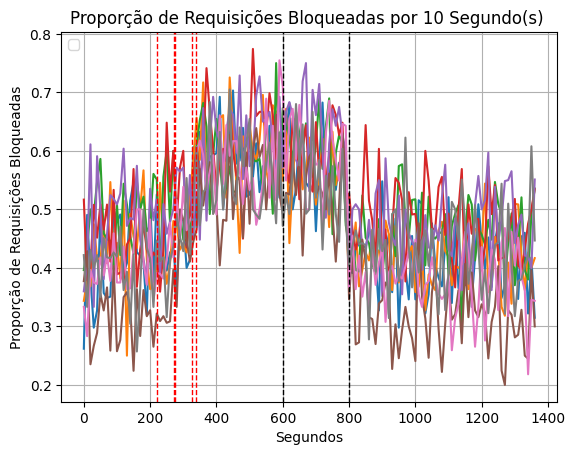

In [12]:

componente1 = [i for i in range(1, 9)]
componente2 = [i for i in range(10, 25)]

for node in componente1:
    componente_oposto = componente1 if node in componente2 else componente2
    filtered_dataframe = dataframe1[
        ((dataframe1['src'] == node) & (dataframe1["dst"].isin(componente_oposto))) | 
        ((dataframe1['src'].isin(componente_oposto)) & (dataframe1["dst"] == node))
        ]
    segundos = (filtered_dataframe['tempo_criacao'] // bucket_size) * bucket_size
    total_requisicoes_por_segundo1 = filtered_dataframe.groupby(segundos).size()

    bloqueadas_por_segundo2 = filtered_dataframe[(filtered_dataframe["bloqueada"] == True)].groupby(segundos).size()
    bloqueadas_por_segundo2 = bloqueadas_por_segundo2.reindex(total_requisicoes_por_segundo1.index, fill_value=0)
    proporcao_bloqueadas1 = bloqueadas_por_segundo2 / total_requisicoes_por_segundo1
    plt.plot(proporcao_bloqueadas1.index, proporcao_bloqueadas1.values)



tempos_de_inicio_migracao_ISP = [ (isp.datacenter.tempo_de_reacao, isp.id) for isp in cenario1.lista_de_ISPs] 

for x in tempos_de_inicio_migracao_ISP:
    plt.axvline(x=x[0], color='red', linestyle='--', linewidth=1)

inicio_desastre = cenario1.desastre.start
fim_desastre = cenario1.desastre.start + cenario1.desastre.duration

#plota inicio e fim do desastre
plt.axvline(x=inicio_desastre, color='black', linestyle='--', linewidth=1)
plt.axvline(x=fim_desastre, color='black', linestyle='--', linewidth=1)


plt.xlabel('Segundos')
plt.ylabel('Proporção de Requisições Bloqueadas')
plt.title(f'Proporção de Requisições Bloqueadas por {bucket_size} Segundo(s) ')
plt.grid(True)
plt.legend(loc = 'upper left')
plt.show()  

In [13]:
def contem_link(caminho, link):
        for i in range(len(caminho) - 1):
            if (caminho[i], caminho[i + 1]) == link or (caminho[i + 1], caminho[i]) == link:
                return True
        return False

In [14]:

def plot_avg_allocated_sum(link, total_slots=200, time_step=0.1, window_size=10):
    # Supondo que 'df' seja o seu DataFrame
    filtered_dataframe = dataframe1[dataframe1["bloqueada"] == False].copy()
    filtered_dataframe['caminho'] = filtered_dataframe['caminho'].apply(eval)  # Convertendo as strings para listas
    filtered_dataframe = filtered_dataframe[filtered_dataframe['caminho'].apply(lambda x: contem_link(x, link))]

    max_time = max(filtered_dataframe['tempo_desalocacao'].max(), filtered_dataframe['tempo_criacao'].max())
    
    # Initialize time points
    time_points = np.arange(10, max_time + time_step, time_step)
    
    # Store allocated_sum for each time step
    allocated_sums = []
    
    for t in time_points:
        # Filter the DataFrame for the current time
        current_requisitions = filtered_dataframe[
            (filtered_dataframe['tempo_criacao'] <= t) & 
            (filtered_dataframe['tempo_desalocacao'] > t)
        ]
        
        # Initialize slots for the current time
        slots = np.zeros(total_slots, dtype=int)
        
        # Get allocated ranges and mark slots
        allocated_requests = current_requisitions['index_de_inicio_e_final'].tolist()
        allocated_requests = [eval(req) for req in allocated_requests]
        
        for start, end in allocated_requests:
            slots[start:end+1] = 1  # +1 to include the last index
        
        # Calculate allocated_sum
        allocated_sum = np.sum(slots)
        allocated_sums.append(allocated_sum)
    
    # Calculate averages over the span of 10 seconds
    window_points = np.arange(0, max_time + time_step, time_step)
    avg_allocated_sums = []
    for t in window_points:
        # Define the window range
        start_time = max(0, t - window_size)
        end_time = t
        
        # Get indices within the window
        indices_in_window = (time_points >= start_time) & (time_points <= end_time)
        avg_allocated_sum = np.mean(np.array(allocated_sums)[indices_in_window])
        avg_allocated_sums.append(avg_allocated_sum)
    
    # Plot the results
    plota_migracao_e_desastre()
    plt.plot(window_points, avg_allocated_sums, label='Quantidade média de slots alocados')
    plt.title(f'Quantidade media de Slots de frequência alocados no link {link} (janela de {window_size} segundos, dados do link coletados a cada {time_step} segundos)')
    plt.xlabel('Tempo (segundos)')
    plt.ylabel('Media de Slots de Frequência Alocados')
    plt.grid(True)
    plt.legend()
    plt.show()

# Call the function with the DataFrame



In [15]:
plt.rcParams["figure.dpi"] = 50

c:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\Local\pypoetry\Cache\virtualenvs\simulador-eon-pre-desastre-dtVYSvzE-py3.12\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\Local\pypoetry\Cache\virtualenvs\simulador-eon-pre-desastre-dtVYSvzE-py3.12\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


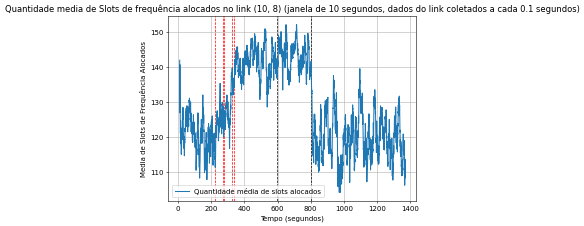

In [16]:
plot_avg_allocated_sum((10, 8))

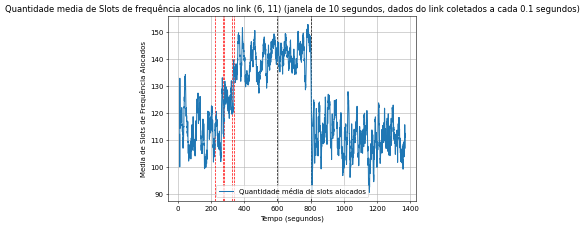

In [17]:

plot_avg_allocated_sum((6,11))

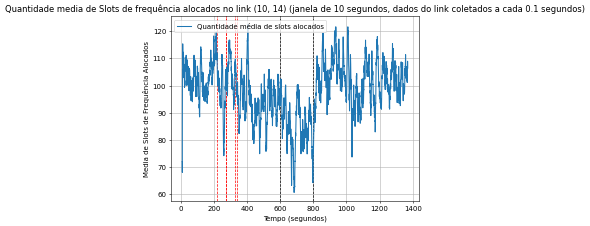

In [18]:

plot_avg_allocated_sum((10,14))

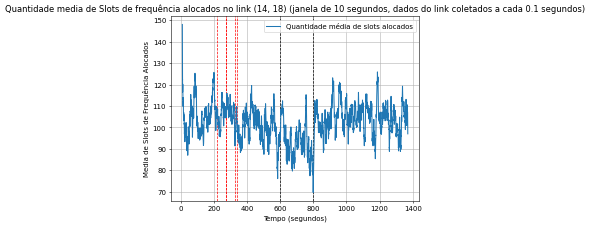

In [19]:

plot_avg_allocated_sum((14,18))

In [20]:

total_slots = 200
X = 100

# Filter based on the conditions
filtered_requisitions = filtered_dataframe[
    (filtered_dataframe['tempo_criacao'] <= X) & 
    (filtered_dataframe['tempo_desalocacao'] > X)
]
slots = np.zeros(total_slots, dtype=int)

# Example DataFrame (you should use your own filtered DataFrame)
# Each request has 'index_de_inicio_e_final' representing [start, end]
allocated_requests = filtered_requisitions['index_de_inicio_e_final'].tolist()
allocated_requests = [eval(req) for req in allocated_requests]
# Mark allocated slots
for start, end in allocated_requests:
    slots[start:end+1] = 1  # +1 to include the last index in the allocation


# Calculate the sum of allocated slots
allocated_sum = np.sum(slots)

# Find the largest continuous window of unallocated slots
unallocated_windows = ''.join(map(str, slots)).split('1')
largest_window = max(len(window) for window in unallocated_windows)

# Print results
print(f"Total allocated slots: {allocated_sum}")
print(f"Largest unallocated window: {largest_window}")


Total allocated slots: 10
Largest unallocated window: 174


In [21]:
def plot_largest_free_window(link, total_slots=200, time_step=0.1, window_size=10):

    # Filter for non-blocked paths and containing the desired link
    filtered_dataframe = dataframe1[dataframe1["bloqueada"] == False].copy()
    filtered_dataframe['caminho'] = filtered_dataframe['caminho'].apply(eval)  # Convert strings to lists
    filtered_dataframe = filtered_dataframe[filtered_dataframe['caminho'].apply(lambda x: contem_link(x, link))]

    # Get the maximum time duration in the dataset
    max_time = max(filtered_dataframe['tempo_desalocacao'].max(), filtered_dataframe['tempo_criacao'].max())

    # Initialize time points
    time_points = np.arange(10, max_time + time_step, time_step)

    # Store the largest free window for each time step
    largest_windows = []

    for t in time_points:
        # Filter the DataFrame for the current time
        current_requisitions = filtered_dataframe[
            (filtered_dataframe['tempo_criacao'] <= t) & 
            (filtered_dataframe['tempo_desalocacao'] > t)
        ]

        # Initialize slots for the current time
        slots = np.zeros(total_slots, dtype=int)

        # Get allocated ranges and mark slots
        allocated_requests = current_requisitions['index_de_inicio_e_final'].tolist()
        allocated_requests = [eval(req) for req in allocated_requests]

        for start, end in allocated_requests:
            slots[start:end+1] = 1  # +1 to include the last index

        # Find the largest free window
        unallocated_windows = ''.join(map(str, slots)).split('1')
        largest_window = max(len(window) for window in unallocated_windows)
        largest_windows.append(largest_window)

    # Calculate averages over the span of 10 seconds
    avg_largest_windows = []
    for t in time_points:
        # Define the window range
        start_time = max(0, t - window_size)
        end_time = t

        # Get indices within the window
        indices_in_window = (time_points >= start_time) & (time_points <= end_time)
        avg_largest_window = np.mean(np.array(largest_windows)[indices_in_window])
        avg_largest_windows.append(avg_largest_window)

    # Plot the results
    plota_migracao_e_desastre()
    plt.plot(time_points, avg_largest_windows, label='Tamanho medio da maior janela livre')
    plt.title(f'Tamanho medio da maior janela livre pelo tempo no link {link} (janela de {window_size}, coletada cada {time_step} segundos)')
    plt.xlabel('Tempo segundos')
    plt.ylabel('Tamanho medio da maior janela livre')
    plt.grid(True)
    plt.legend()
    plt.show()


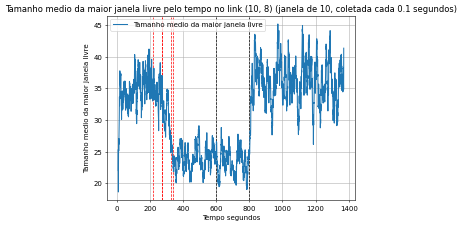

In [22]:

plot_largest_free_window((10,8))


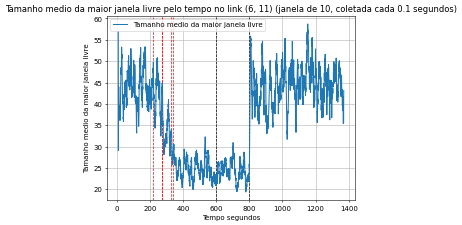

In [23]:
plot_largest_free_window((6,11))

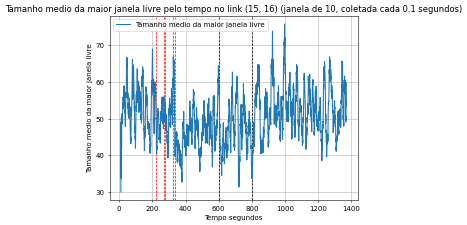

In [24]:
plot_largest_free_window((15,16))

In [25]:
from collections import defaultdict

dict_nodes_para_distancia_minima_entre_nodes = {}
dict_distancia_minima_entre_nodes_para_nodes = defaultdict(list)
for node1 in cenario1.topology.topology:
    for node2 in cenario1.topology.topology:
        if node1 == node2:
            continue

        menor_caminho = cenario1.topology.caminhos_mais_curtos_entre_links[node1][node2][0]["caminho"]
        tamanho_menor_caminho = len(menor_caminho) - 1
        dict_nodes_para_distancia_minima_entre_nodes[(node1, node2)] = tamanho_menor_caminho
        dict_distancia_minima_entre_nodes_para_nodes[tamanho_menor_caminho].append((node1, node2))


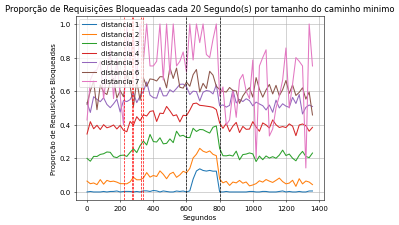

In [26]:

bucket_size = 20
for distancia, links in dict_distancia_minima_entre_nodes_para_nodes.items():
    filtered_dataframe = dataframe1[dataframe1.apply(lambda row: (row["src"], row["dst"]) in links, axis=1)]


    segundos = (filtered_dataframe['tempo_criacao'] // bucket_size) * bucket_size
    total_requisicoes_por_segundo1 = filtered_dataframe.groupby(segundos).size()

    bloqueadas_por_segundo2 = filtered_dataframe[(filtered_dataframe["bloqueada"] == True)].groupby(segundos).size()
    bloqueadas_por_segundo2 = bloqueadas_por_segundo2.reindex(total_requisicoes_por_segundo1.index, fill_value=0)
    proporcao_bloqueadas1 = bloqueadas_por_segundo2 / total_requisicoes_por_segundo1
    plt.plot(proporcao_bloqueadas1.index, proporcao_bloqueadas1.values, label=f"distancia {distancia}")





tempos_de_inicio_migracao_ISP = [ (isp.datacenter.tempo_de_reacao, isp.id) for isp in cenario1.lista_de_ISPs] 

for x in tempos_de_inicio_migracao_ISP:
    plt.axvline(x=x[0], color='red', linestyle='--', linewidth=1)

inicio_desastre = cenario1.desastre.start
fim_desastre = cenario1.desastre.start + cenario1.desastre.duration

#plota inicio e fim do desastre
plt.axvline(x=inicio_desastre, color='black', linestyle='--', linewidth=1)
plt.axvline(x=fim_desastre, color='black', linestyle='--', linewidth=1)


plt.xlabel('Segundos')
plt.ylabel('Proporção de Requisições Bloqueadas')
plt.title(f'Proporção de Requisições Bloqueadas cada {bucket_size} Segundo(s) por tamanho do caminho minimo')
plt.grid(True)
plt.legend(loc = 'upper left')
plt.show()  

In [27]:
distancia_media_do_componente1_para_componente2 = 0

for node1 in componente1:
    for node2 in componente2:
        distancia_media_do_componente1_para_componente2 += dict_nodes_para_distancia_minima_entre_nodes[(node1, node2)]
distancia_media_do_componente1_para_componente2 /= len(componente1) * len(componente2)

print(f"distancia media do componente 1 para o componente 2: {distancia_media_do_componente1_para_componente2}")
distancia_media_do_componente1_para_componente1 = 0
for node1 in componente1:
    for node2 in componente1:
        if node1 == node2:
            continue
        distancia_media_do_componente1_para_componente1 += dict_nodes_para_distancia_minima_entre_nodes[(node1, node2)]
distancia_media_do_componente1_para_componente1 /= len(componente1) * (len(componente1) - 1)

print(f"distancia media do componente 1 para o componente 1: {distancia_media_do_componente1_para_componente1}")


distancia_media_do_componente2_para_componente2 = 0
for node1 in componente2:
    for node2 in componente2:
        if node1 == node2:
            continue
        distancia_media_do_componente2_para_componente2 += dict_nodes_para_distancia_minima_entre_nodes[(node1, node2)]
distancia_media_do_componente2_para_componente2 /= len(componente2) * (len(componente2) - 1)

print(f"distancia media do componente 2 para o componente 2: {distancia_media_do_componente2_para_componente2}")

distancia media do componente 1 para o componente 2: 4.008333333333334
distancia media do componente 1 para o componente 1: 1.8571428571428572
distancia media do componente 2 para o componente 2: 2.4857142857142858


In [28]:

dict_node_numero_de_vizinhos = {}
dict_numero_de_vizinhos_por_nodes = defaultdict(list)
bucket_size = 10
for node in cenario1.topology.topology:
    numero_de_vizinhos = len(list(cenario1.topology.topology.neighbors(node)))
    dict_node_numero_de_vizinhos[node] = numero_de_vizinhos
    dict_numero_de_vizinhos_por_nodes[dict_node_numero_de_vizinhos[node]].append(node)
    

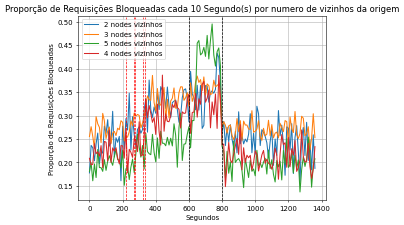

In [29]:

for numero_de_vizinhos, nodes in dict_numero_de_vizinhos_por_nodes.items():

    filtered_dataframe = dataframe1[dataframe1.apply(lambda row: row["src"] in nodes, axis=1)]
    
    segundos = (filtered_dataframe['tempo_criacao'] // bucket_size) * bucket_size
    total_requisicoes_por_segundo1 = filtered_dataframe.groupby(segundos).size()

    bloqueadas_por_segundo2 = filtered_dataframe[(filtered_dataframe["bloqueada"] == True)].groupby(segundos).size()
    bloqueadas_por_segundo2 = bloqueadas_por_segundo2.reindex(total_requisicoes_por_segundo1.index, fill_value=0)
    proporcao_bloqueadas1 = bloqueadas_por_segundo2 / total_requisicoes_por_segundo1
    plt.plot(proporcao_bloqueadas1.index, proporcao_bloqueadas1.values, label=f"{numero_de_vizinhos} nodes vizinhos")



tempos_de_inicio_migracao_ISP = [ (isp.datacenter.tempo_de_reacao, isp.id) for isp in cenario1.lista_de_ISPs] 

for x in tempos_de_inicio_migracao_ISP:
    plt.axvline(x=x[0], color='red', linestyle='--', linewidth=1)

inicio_desastre = cenario1.desastre.start
fim_desastre = cenario1.desastre.start + cenario1.desastre.duration

#plota inicio e fim do desastre
plt.axvline(x=inicio_desastre, color='black', linestyle='--', linewidth=1)
plt.axvline(x=fim_desastre, color='black', linestyle='--', linewidth=1)


plt.xlabel('Segundos')
plt.ylabel('Proporção de Requisições Bloqueadas')
plt.title(f'Proporção de Requisições Bloqueadas cada {bucket_size} Segundo(s) por numero de vizinhos da origem')
plt.grid(True)
plt.legend(loc = 'upper left')
plt.show()  

In [30]:
##alterar para observar apenas trafego entre componentes
def calcula_bloqueio_antes_da_migracao(dataframe: pd.DataFrame, node: int, cenario: Cenario):
    tempos_de_inicio_migracao_ISP = [ (isp.datacenter.tempo_de_reacao, isp.id) for isp in cenario.lista_de_ISPs]
    primeiro_tempo = min([x[0] for x in tempos_de_inicio_migracao_ISP])
    numero_de_bloqueadas_antes_migracao = len(dataframe[(dataframe["bloqueada"] == True) &
                                                         ( dataframe["src"] == node) &
                                                         (dataframe["tempo_criacao"] < primeiro_tempo)])
    numero_de_req_antes_migracao = len(dataframe[( dataframe["src"] == node) 
                                                  & (dataframe["tempo_criacao"] < primeiro_tempo)])
    return  numero_de_bloqueadas_antes_migracao / numero_de_req_antes_migracao

def calcula_bloqueio_durante_migracao(dataframe: pd.DataFrame, node: int, cenario: Cenario):
    tempos_de_inicio_migracao_ISP = [ (isp.datacenter.tempo_de_reacao, isp.id) for isp in cenario.lista_de_ISPs]
    primeiro_tempo = min([x[0] for x in tempos_de_inicio_migracao_ISP])
    numero_de_bloqueadas_durante_migracao = len(dataframe[(dataframe["bloqueada"] == True) &
                                                         ( dataframe["src"] == node) &
                                                         (dataframe["tempo_criacao"] > primeiro_tempo) &
                                                         (dataframe["tempo_criacao"] < cenario.desastre.start)])
    
    numero_de_req_durante_migracao = len(dataframe[( dataframe["src"] == node) &
                                                  (dataframe["tempo_criacao"] > primeiro_tempo) &
                                                  (dataframe["tempo_criacao"] < cenario.desastre.start)])
    return  numero_de_bloqueadas_durante_migracao / numero_de_req_durante_migracao


def calcula_bloqueio_durante_desastre(dataframe: pd.DataFrame, node: int, cenario: Cenario):

    numero_de_bloqueadas_durante_migracao = len(dataframe[(dataframe["bloqueada"] == True) &
                                                         ( dataframe["src"] == node) &
                                                         (dataframe["tempo_criacao"] > cenario.desastre.start) &
                                                         (dataframe["tempo_criacao"] < cenario.desastre.start + cenario.desastre.duration)])
    
    numero_de_req_durante_migracao = len(dataframe[( dataframe["src"] == node) &
                                                (dataframe["tempo_criacao"] > cenario.desastre.start) &
                                                (dataframe["tempo_criacao"] < cenario.desastre.start + cenario.desastre.duration)])
    return  numero_de_bloqueadas_durante_migracao / numero_de_req_durante_migracao


In [31]:
node = 9

calcula_bloqueio_antes_da_migracao(dataframe1, node, cenario1)

0.1546692607003891

In [32]:
calcula_bloqueio_durante_migracao(dataframe1, node, cenario1)

0.08216216216216216

In [33]:
trafego_extra_componente = dataframe1[
    ((dataframe1['src'].isin(componente1)) & (dataframe1["dst"].isin(componente2))) | 
    ((dataframe1['src'].isin(componente2)) & (dataframe1["dst"].isin(componente1)))
]
trafego_intra_componente = dataframe1[
    ((dataframe1['src'].isin(componente1)) & (dataframe1["dst"].isin(componente1))) | 
    ((dataframe1['src'].isin(componente2)) & (dataframe1["dst"].isin(componente2)))
]

In [34]:
def retorna_dict_de_delta_bloqueios_por_node(dataframe: pd.DataFrame, cenario: Cenario):
    dict_de_delta_bloqueios = {}
    for node in cenario.topology.topology.nodes:
        if node == 9:
            continue
        bloqueio_antes = calcula_bloqueio_antes_da_migracao(dataframe, node, cenario)
        bloqueio_durante = calcula_bloqueio_durante_migracao(dataframe, node, cenario)
        bloqueio_antes = 1-bloqueio_antes
        bloqueio_durante = 1-bloqueio_durante
        dict_de_delta_bloqueios[node]= { 
            "texto":f"node {node:02d}, delta bloqueio {(bloqueio_durante - bloqueio_antes)*100:.4f}%, razão {(bloqueio_durante / bloqueio_antes)*100:.4f}%, " + 
              f"bloqueio antes {bloqueio_antes*100:.4f}%, bloqueio durante {bloqueio_durante*100:.4f}%", 
            "delta":(bloqueio_durante - bloqueio_antes)*100, "razão":(bloqueio_durante/ bloqueio_antes)*100, "bloqueio_antes": bloqueio_antes, "bloqueio_durante": bloqueio_durante}
    return dict_de_delta_bloqueios

In [35]:
dict_delta_bloqueios = retorna_dict_de_delta_bloqueios_por_node(dataframe1, cenario1)
dict_delta_bloqueios = retorna_dict_de_delta_bloqueios_por_node(trafego_extra_componente, cenario1)


In [36]:
for value in dict_delta_bloqueios.values():
    print(value["texto"])

node 01, delta bloqueio -13.5649%, razão 76.9397%, bloqueio antes 58.8235%, bloqueio durante 45.2586%
node 02, delta bloqueio -13.7272%, razão 75.6752%, bloqueio antes 56.4327%, bloqueio durante 42.7056%
node 06, delta bloqueio -16.0632%, razão 75.9796%, bloqueio antes 66.8731%, bloqueio durante 50.8099%
node 03, delta bloqueio -8.4603%, razão 83.6784%, bloqueio antes 51.8349%, bloqueio durante 43.3746%
node 07, delta bloqueio -15.7627%, razão 74.1475%, bloqueio antes 60.9718%, bloqueio durante 45.2091%
node 04, delta bloqueio -13.1082%, razão 76.3699%, bloqueio antes 55.4723%, bloqueio durante 42.3641%
node 05, delta bloqueio -11.5249%, razão 77.6398%, bloqueio antes 51.5419%, bloqueio durante 40.0170%
node 08, delta bloqueio -10.5998%, razão 81.7218%, bloqueio antes 57.9915%, bloqueio durante 47.3917%
node 11, delta bloqueio -21.9047%, razão 74.1915%, bloqueio antes 84.8739%, bloqueio durante 62.9693%
node 10, delta bloqueio -18.9790%, razão 77.4963%, bloqueio antes 84.3373%, bloquei

In [37]:
delta_degradação = [ value["delta"] for value in dict_delta_bloqueios.values()]
razao_degradação = [ value["razão"] for value in dict_delta_bloqueios.values()]
min_delta = min(delta_degradação)
max_delta = max(delta_degradação)
min_razao = min(razao_degradação)
max_razao = max(razao_degradação)

print(f"maximo delta degradação {max_delta:.4f}%, minimum delta degradação {min_delta:.4f}%, variancia {np.var(delta_degradação):.4f}, media {np.mean(delta_degradação):.4f}")
print(f"maximo razão degradação {max_razao:.4f}%, minimum razão degradação {min_razao:.4f}%, variancia {np.var(razao_degradação):.4f}, media {np.mean(razao_degradação):.4f}")

maximo delta degradação -2.1776%, minimum delta degradação -25.8604%, variancia 29.7482, media -12.4510
maximo razão degradação 94.9292%, minimum razão degradação 65.8719%, variancia 37.4098, media 79.1100


In [38]:
G = cenario1.topology.topology
topologia_desastre = nx.Graph()
topologia_desastre.add_weighted_edges_from( edge for edge in G.edges(data=True) if edge[2]['vai falhar'] == False)
topologia_desastre.nodes

NodeView((1, 2, 6, 3, 7, 11, 4, 5, 8, 10, 19, 15, 12, 13, 14, 16, 17, 18, 20, 22, 21, 23, 24))

In [39]:

from collections import defaultdict
node_fonte = 1
node_destino = 23
def retorna_criticidade_dos_links_da_topologia(nodes, caminhos):
    links_mais_usados_por_topologia = defaultdict(lambda: defaultdict(int))

    for node_fonte in nodes:
        criticidade_links = retorna_criticidade_dos_links_de_certo_node( caminhos, node_fonte)
        for link, soma_dos_index_do_caminho in criticidade_links.items():
            for index_caminho, valor in soma_dos_index_do_caminho.items():
                links_mais_usados_por_topologia[link][index_caminho] += valor


    for key, value in links_mais_usados_por_topologia.items():
        links_mais_usados_por_topologia[key] = dict(value) 

    return dict(links_mais_usados_por_topologia)


def retorna_criticidade_dos_links_de_certo_node(caminhos, node_fonte: int):
    
    
    links_mais_usados_por_node = defaultdict(lambda: defaultdict(int))
    if node_fonte not in caminhos:
        return dict(links_mais_usados_por_node)
    for node_destino in caminhos[node_fonte]:
        criticidade_links = retorna_criticidade_dos_links_de_certo_node_para_certo_node( caminhos, node_fonte, node_destino)
        for link, soma_dos_index_do_caminho in criticidade_links.items():
            for index_caminho, valor in soma_dos_index_do_caminho.items():
                links_mais_usados_por_node[link][index_caminho] += valor


    for key, value in links_mais_usados_por_node.items():
        links_mais_usados_por_node[key] = dict(value) 
        
    return dict(links_mais_usados_por_node)

def retorna_criticidade_dos_links_de_certo_node_para_certo_node( caminhos, node_fonte: int, node_destino: int ):
    links_mais_usados_por_node = defaultdict(lambda: defaultdict(int))

    infoCaminhos = caminhos[node_fonte][node_destino]
    caminhos = [infoCaminho['caminho'] for infoCaminho in infoCaminhos]
    for j, caminho in enumerate(caminhos):
        for i in range(len(caminho)-1):
            link = (caminho[i], caminho[i+1])
            links_mais_usados_por_node[link][j] += 1
        

    for key, value in links_mais_usados_por_node.items():
        links_mais_usados_por_node[key] = dict(value) 

    return dict(links_mais_usados_por_node)

ocorrencia_links_original = retorna_criticidade_dos_links_da_topologia(cenario1.topology.topology.nodes, cenario1.topology.caminhos_mais_curtos_entre_links)
ocorrencia_links_desastre = retorna_criticidade_dos_links_da_topologia(cenario1.topology.topology.nodes, cenario1.topology.caminhos_mais_curtos_entre_links_durante_desastre)

diferenca_ocorrencia_links = defaultdict( lambda: defaultdict(int))
lista_diferenca = []

for key, value in ocorrencia_links_original.items():
    soma_original = sum(value.values())
    soma_desastre = sum(ocorrencia_links_desastre[key].values()) if key in ocorrencia_links_desastre else 0    
    src, dst = key
    insert_key = (src, dst) if src > dst else (dst, src)


    diferenca_ocorrencia_links[insert_key]["diferenca"] += (soma_desastre - soma_original)
    diferenca_ocorrencia_links[insert_key]["soma_original"] += soma_original
    diferenca_ocorrencia_links[insert_key]["soma_desastre"] += soma_desastre

for key, value in diferenca_ocorrencia_links.items():

    soma_original = value["soma_original"]
    soma_desastre = value["soma_desastre"]
    diferenca = value["diferenca"]
    diferenca_ocorrencia_links[key]["porcentagem_ocorrencia_pre_desastre"] = soma_original/(24*24)
    diferenca_ocorrencia_links[key]["porcentagem_ocorrencia_desastre"] = soma_desastre/(24*24)
    lista_diferenca.append((key, soma_original, soma_desastre, diferenca))
    print(f" link {key}, ocorrencia original = {soma_original}, ocorrencia desastre = {soma_desastre}, diferença = {diferenca}")


 link (2, 1), ocorrencia original = 266, ocorrencia desastre = 334, diferença = 68
 link (6, 1), ocorrencia original = 418, ocorrencia desastre = 410, diferença = -8
 link (6, 2), ocorrencia original = 479, ocorrencia desastre = 501, diferença = 22
 link (7, 6), ocorrencia original = 593, ocorrencia desastre = 774, diferença = 181
 link (7, 3), ocorrencia original = 545, ocorrencia desastre = 501, diferença = -44
 link (3, 2), ocorrencia original = 337, ocorrencia desastre = 583, diferença = 246
 link (7, 4), ocorrencia original = 629, ocorrencia desastre = 540, diferença = -89
 link (4, 3), ocorrencia original = 543, ocorrencia desastre = 620, diferença = 77
 link (9, 6), ocorrencia original = 752, ocorrencia desastre = 0, diferença = -752
 link (9, 7), ocorrencia original = 1153, ocorrencia desastre = 0, diferença = -1153
 link (5, 4), ocorrencia original = 366, ocorrencia desastre = 564, diferença = 198
 link (5, 3), ocorrencia original = 225, ocorrencia desastre = 364, diferença = 

In [40]:

lista_diferenca_ordenada_pela_diferenca = sorted(lista_diferenca, key=lambda x: x[3], reverse=True)
print(24*23)
for link, soma_original, soma_desastre, diferenca in lista_diferenca_ordenada_pela_diferenca:
    if link in [ (10, 8), (11, 6)]:
        print(f" \033[32mlink {str(link):>8}, ocorrencia original = {str(soma_original):>4}, ocorrencia desastre = {str(soma_desastre):>4}, diferença = {str(diferenca):>5}, diferença percentual = {soma_desastre/soma_original*100:.4f}%\033[0m")
    else:
        print(f" link {str(link):>8}, ocorrencia original = {str(soma_original):>4}, ocorrencia desastre = {str(soma_desastre):>4}, diferença = {str(diferenca):>5}, diferença percentual = {soma_desastre/soma_original*100:.4f}%")

552
 link  (10, 8), ocorrencia original =  737, ocorrencia desastre = 1509, diferença =   772, diferença percentual = 204.7490%
 link  (11, 6), ocorrencia original =  340, ocorrencia desastre =  999, diferença =   659, diferença percentual = 293.8235%
 link   (8, 7), ocorrencia original =  430, ocorrencia desastre =  881, diferença =   451, diferença percentual = 204.8837%
 link (13, 10), ocorrencia original =  717, ocorrencia desastre = 1099, diferença =   382, diferença percentual = 153.2775%
 link   (8, 5), ocorrencia original =  373, ocorrencia desastre =  732, diferença =   359, diferença percentual = 196.2466%
 link   (3, 2), ocorrencia original =  337, ocorrencia desastre =  583, diferença =   246, diferença percentual = 172.9970%
 link (12, 11), ocorrencia original =  613, ocorrencia desastre =  851, diferença =   238, diferença percentual = 138.8254%
 link (17, 13), ocorrencia original =  966, ocorrencia desastre = 1175, diferença =   209, diferença percentual = 121.6356%
 lin

In [41]:
lista_diferenca_ordenada_pela_razao = sorted(lista_diferenca, key=lambda x: x[2]/x[1], reverse=True)
for link, soma_original, soma_desastre, diferenca in lista_diferenca_ordenada_pela_razao:
    if link in [ (10, 8), (11, 6)]:
        print(f" \033[32mlink {str(link):>8}, ocorrencia original = {str(soma_original):>4}, ocorrencia desastre = {str(soma_desastre):>4}, diferença = {str(diferenca):>5}, diferença percentual = {soma_desastre/soma_original*100:.4f}%\033[0m")
    else:
        print(f" link {str(link):>8}, ocorrencia original = {str(soma_original):>4}, ocorrencia desastre = {str(soma_desastre):>4}, diferença = {str(diferenca):>5}, diferença percentual = {soma_desastre/soma_original*100:.4f}%")

 link  (11, 6), ocorrencia original =  340, ocorrencia desastre =  999, diferença =   659, diferença percentual = 293.8235%
 link   (8, 7), ocorrencia original =  430, ocorrencia desastre =  881, diferença =   451, diferença percentual = 204.8837%
 link  (10, 8), ocorrencia original =  737, ocorrencia desastre = 1509, diferença =   772, diferença percentual = 204.7490%
 link   (8, 5), ocorrencia original =  373, ocorrencia desastre =  732, diferença =   359, diferença percentual = 196.2466%
 link   (3, 2), ocorrencia original =  337, ocorrencia desastre =  583, diferença =   246, diferença percentual = 172.9970%
 link   (5, 3), ocorrencia original =  225, ocorrencia desastre =  364, diferença =   139, diferença percentual = 161.7778%
 link   (5, 4), ocorrencia original =  366, ocorrencia desastre =  564, diferença =   198, diferença percentual = 154.0984%
 link (13, 10), ocorrencia original =  717, ocorrencia desastre = 1099, diferença =   382, diferença percentual = 153.2775%
 link (1

In [42]:
lista_diferenca_ordenada_pela_ocorrencia_desastre = sorted(lista_diferenca, key=lambda x: x[2], reverse=True)
for link, soma_original, soma_desastre, diferenca in lista_diferenca_ordenada_pela_ocorrencia_desastre:
    if link in [ (10, 8), (11, 6)]:
        print(f" \033[32mlink {str(link):>8}, ocorrencia original = {str(soma_original):>4}, ocorrencia desastre = {str(soma_desastre):>4}, diferença = {str(diferenca):>5}, diferença percentual = {soma_desastre/soma_original*100:.4f}%\033[0m")
    else:
        print(f" link {str(link):>8}, ocorrencia original = {str(soma_original):>4}, ocorrencia desastre = {str(soma_desastre):>4}, diferença = {str(diferenca):>5}, diferença percentual = {soma_desastre/soma_original*100:.4f}%")

 link  (10, 8), ocorrencia original =  737, ocorrencia desastre = 1509, diferença =   772, diferença percentual = 204.7490%
 link (17, 13), ocorrencia original =  966, ocorrencia desastre = 1175, diferença =   209, diferença percentual = 121.6356%
 link (13, 10), ocorrencia original =  717, ocorrencia desastre = 1099, diferença =   382, diferença percentual = 153.2775%
 link (13, 12), ocorrencia original =  925, ocorrencia desastre = 1026, diferença =   101, diferença percentual = 110.9189%
 link (16, 12), ocorrencia original = 1351, ocorrencia desastre = 1023, diferença =  -328, diferença percentual = 75.7217%
 link  (11, 6), ocorrencia original =  340, ocorrencia desastre =  999, diferença =   659, diferença percentual = 293.8235%
 link (22, 21), ocorrencia original =  878, ocorrencia desastre =  957, diferença =    79, diferença percentual = 108.9977%
 link (22, 17), ocorrencia original =  725, ocorrencia desastre =  887, diferença =   162, diferença percentual = 122.3448%
 link   (

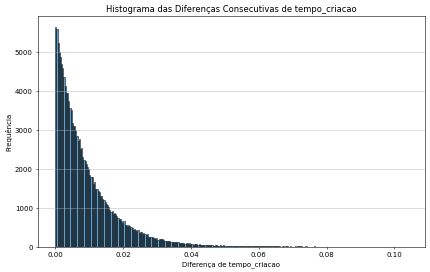

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

# Exemplo: DataFrame com a coluna 'tempo_criacao'
# Ordenar pela coluna 'tempo_criacao'
dataframe1 = dataframe1.sort_values(by='tempo_criacao')

# Calcular a diferença entre valores consecutivos
dataframe1['diferenca'] = dataframe1['tempo_criacao'].diff()

# Criar o histograma
plt.figure(figsize=(10, 6))
plt.hist(dataframe1['diferenca'].dropna(), bins=300, edgecolor='black', alpha=0.7)
plt.title('Histograma das Diferenças Consecutivas de tempo_criacao')
plt.xlabel('Diferença de tempo_criacao')
plt.ylabel('Frequência')
plt.grid(axis='y', alpha=0.75)
plt.show()



Drama papper